based off https://www.tensorflow.org/tutorials/generative/dcgan

### Setup

In [1]:
import tensorflow as tf

In [3]:
tf.__version__

'2.13.0'

In [7]:
%%capture output
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Dataset Prep

In [3]:
# for mac ssh errors: https://stackoverflow.com/questions/42098126/mac-osx-python-ssl-sslerror-ssl-certificate-verify-failed-certificate-verify
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # normalize

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create Models

##### Generator

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is batch shape

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
    

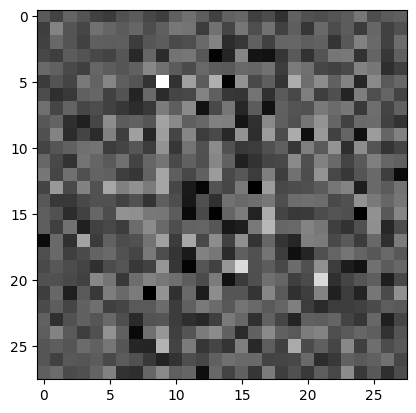

In [8]:
# untrained test
generator = make_generator_model()

noise = tf.random.normal([1, 100]) # 1 noise vector w/ length 100
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0, :, :, 0], cmap='gray') # batch, all spacial dims, channel

##### Discriminator

In [15]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
# untrained test
discriminator = make_discriminator()

decision = discriminator(generated_img)
print(decision)

tf.Tensor([[0.00230551]], shape=(1, 1), dtype=float32)


### Loss Functions & Optimizers

In [19]:
# helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### Discriminator Loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

##### Generator Loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real. Here, compare the discriminators decisions on the generated images to an array of 1s.

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

##### Optimizers

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### Checkpoints & Saving

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training Functions

In [27]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [35]:
img_path = 'images'

In [29]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # backprop
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
# helper function to visualize images during training
def generate_and_save_images(model, epoch, test_input):
    # training set to false --> layers run in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(img_path, epoch))
    plt.show()

In [30]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # produce images as model is trained
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # generate after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

### Training the Model

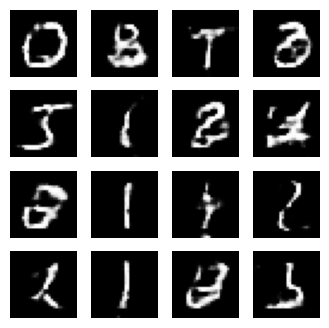

In [34]:
train(train_dataset, EPOCHS)

### Restoring a checkpoint

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Creating a GIF / Inference

In [55]:
def display_image(epoch_no):
    return PIL.Image.open('{}/image_at_epoch_{:04d}.png'.format(img_path, epoch_no))

ValueError: Could not save to JPEG for display

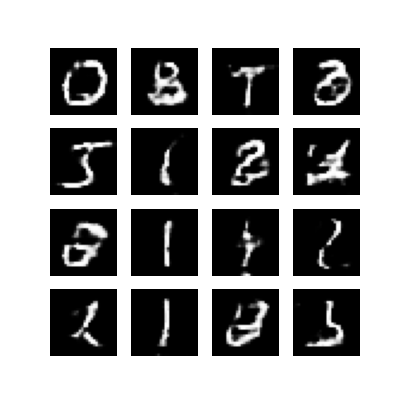

In [57]:
display_image(EPOCHS)

In [73]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(f'{img_path}/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_40429/1027177170.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_40429/1027177170.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [74]:
import tensorflow_docs.vis.embed as embed


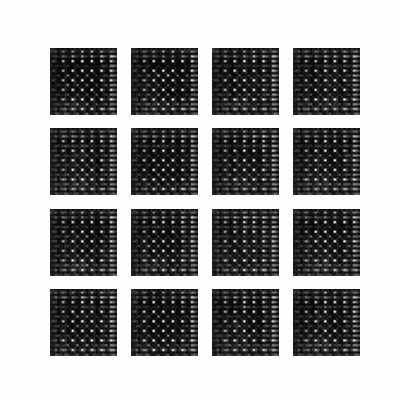

In [75]:
embed.embed_file(anim_file)